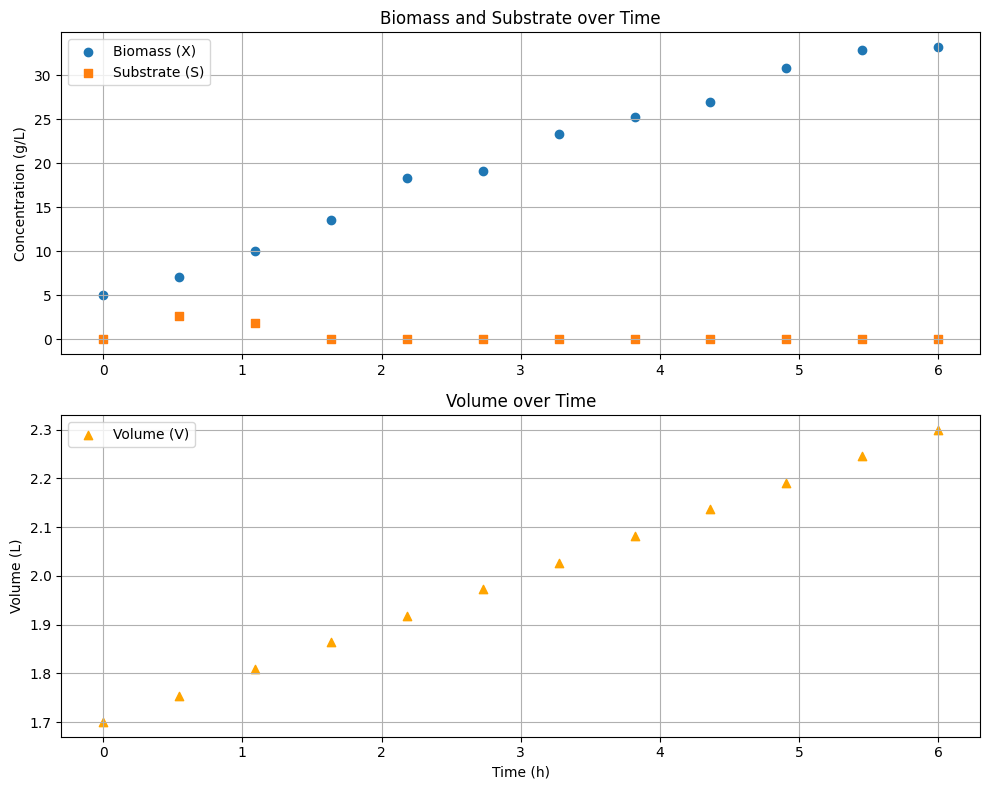

In [17]:
import copy
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from tqdm import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of data points
NUM_SAMPLES = 1000
# Parameter values
NUM_EPOCHS = 100000
LEARNING_RATE = 1e-4
NUM_COLLOCATION = 1000
PATIENCE = 1000
THRESHOLD = 1e-6
EARLY_STOPPING_EPOCH = 10000
VERBOSE = 1000
# Number of collocation points
NUM_COLLOCATION_POINTS = 100

# --- Model Parameters ---
MU_MAX = 0.86980    # 1/h
K_S = 0.000123762    # g/l
Y_XS = 0.435749      # g/g
S_F = 286           # g/l
K_I    = 33           # g/l
k_d    = 0.03        # 1/h

# Noise parameters
BIOMASS_NOISE = 0.035
SUBSTRATE_NOISE = 0.03

# Initial Conditions
X_0, S_0, V_0 = 5, 0.013, 1.7  # Biomass, Substrate, Volume

F_0 = 0.1  # Initial flow rate

# ODE solver parameters
ODE_SOLVER = 'LSODA'

# Time parameters
T_START = 0
T_END = 6
TIME_RANGE = int(T_END - T_START) # Absolute time 

# Actual system dynamics
def actual_system(t: float, y: float, F: float):
    ''' Real system model with cell death and substrate inhibition '''
    X, S, V = y
    mu = MU_MAX * S / (K_S + S + S**2 / K_I)  # Monod equation
    dX_dt = mu * X - (F / V) * X - k_d * X
    dS_dt = -(1 / Y_XS) * mu * X + (F / V) * (S_F - S) 
    dV_dt = F
    return [dX_dt, dS_dt, dV_dt]

def solve_ode(ode: callable, t_span: list, y0: list, method: str, t_eval: list, args: tuple) -> solve_ivp:
    sol = solve_ivp(ode, t_span=t_span, y0=y0, method=method, args=args, t_eval=t_eval, rtol=1e-6, atol=1e-12)
    # sol.y = np.maximum(sol.y, 0)
    return sol

# Generate synthetic data
t_eval = np.linspace(T_START, T_END, 12)
sol = solve_ode(actual_system, t_span=[T_START, T_END], 
                y0=[X_0, S_0, V_0], method=ODE_SOLVER, 
                t_eval=t_eval, args=(F_0,))
sol.y[0][1:] += np.random.normal(0, max(0, sol.y[0].max()) * BIOMASS_NOISE, size=sol.y[0][1:].shape)
sol.y[1][1:] += np.random.normal(0, max(0, sol.y[1].max()) * SUBSTRATE_NOISE, size=sol.y[1][1:].shape)
sol.y[1][1:] = np.maximum(sol.y[1][1:], 0)
df = pd.DataFrame(sol.y.T, columns=['Biomass', 'Substrate', 'Volume'])
df['Time'] = sol.t

# Plot the data
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=False)
axs[0].scatter(df['Time'], df['Biomass'], label='Biomass (X)', marker='o')
axs[0].scatter(df['Time'], df['Substrate'], label='Substrate (S)', marker='s')
axs[0].set_ylabel('Concentration (g/L)')
axs[0].legend()
axs[0].grid()
axs[0].set_title('Biomass and Substrate over Time')
axs[1].scatter(df['Time'], df['Volume'], label='Volume (V)', marker='^', color='orange')
axs[1].set_xlabel('Time (h)')
axs[1].set_ylabel('Volume (L)')
axs[1].legend()
axs[1].grid()
axs[1].set_title('Volume over Time')
plt.tight_layout()
plt.show()

In [18]:
def numpy_to_tensor(array, requires_grad=False):
    return torch.tensor(array, requires_grad=requires_grad, dtype=torch.float32).to(DEVICE).reshape(-1, 1)

def grad(outputs, inputs):
    return torch.autograd.grad(outputs.sum(), inputs, create_graph=True)[0]

class PINN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.input = nn.Linear(input_dim, 64)
        self.hidden1 = nn.Linear(64, 1024)
        self.hidden  = nn.Linear(1024, 1024)
        self.hidden2 = nn.Linear(1024, 64)
        self.output = nn.Linear(64, output_dim)
        
        self.mu_max = nn.Parameter(torch.tensor(0.8, dtype=torch.float32))
        self.K_s = nn.Parameter(torch.tensor(0.1, dtype=torch.float32))
        self.Y_xs = nn.Parameter(torch.tensor(0.5, dtype=torch.float32))

    def forward(self, x):
        x = torch.tanh(self.input(x))
        x = torch.tanh(self.hidden1(x))
        x = torch.tanh(self.hidden(x))
        x = torch.tanh(self.hidden2(x))
        x = self.output(x)
        return x

In [19]:
def loss_fn(net: nn.Module) -> torch.Tensor:
    t_col = torch.linspace(T_START, T_END, steps=NUM_COLLOCATION).view(-1, 1).requires_grad_(True).to(DEVICE)
    F_col = torch.ones_like(t_col) * F_0
    
    preds = net.forward(t_col)
    X_pred = preds[:, 0].view(-1, 1)
    S_pred = preds[:, 1].view(-1, 1)
    # V_pred = preds[:, 2].view(-1, 1)
    V_pred = V_0 + F_col * t_col
    
    dXdt_pred = grad(X_pred, t_col)
    dSdt_pred = grad(S_pred, t_col)
    dVdt_pred = grad(V_pred, t_col)
    
    
    mu = net.mu_max * S_pred / (net.K_s + S_pred)
    
    error_dXdt = dXdt_pred - (mu * X_pred - (F_col / V_pred) * X_pred)
    error_dSdt = dSdt_pred - (-(1 / net.Y_xs) * mu * X_pred + (F_col / V_pred) * (S_F - S_pred))
    error_dVdt = dVdt_pred - F_col
    
    # average residual squared loss
    w_X, w_S, w_V = 0.6, 0.4, 0.0
    loss_ode = torch.mean(error_dXdt**2) * w_X + \
               torch.mean(error_dSdt**2) * w_S + \
               torch.mean(error_dVdt**2) * w_V
    
    return loss_ode


In [20]:
t_train = numpy_to_tensor(df['Time'].values)
X_train = numpy_to_tensor(df['Biomass'].values)
S_train = numpy_to_tensor(df['Substrate'].values)
V_train = numpy_to_tensor(df['Volume'].values)

out_train = torch.cat((X_train, S_train, V_train), dim=1)

net = PINN(input_dim=1, output_dim=3).to(DEVICE)

optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.75)

# Loss weights
w_data, w_ode, w_ic = 1, 10, 1

# Initialize early stopping variables
best_loss = float("inf")
best_model_weights = None
patience = PATIENCE
threshold = THRESHOLD
pretrain_epochs = 0

LOSS_DATA = []
LOSS_ODE = []
LOSS_IC = []

for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()
    preds = net.forward(t_train)
    X_pred = preds[:, 0].view(-1, 1)
    S_pred = preds[:, 1].view(-1, 1)
    V_pred = preds[:, 2].view(-1, 1)
    
    w_X, w_S, w_V = 0.5, 0.4, 0.1
    loss_data = torch.mean((X_pred - out_train[:, 0].view(-1, 1))**2) * w_X + \
                torch.mean((S_pred - out_train[:, 1].view(-1, 1))**2) * w_S + \
                torch.mean((V_pred - out_train[:, 2].view(-1, 1))**2) * w_V
    
    LOSS_DATA.append(loss_data.item())
    
    if epoch < pretrain_epochs:
        loss = loss_data * w_data
    else:  
        loss_ode = loss_fn(net) * w_ode
        loss_ic = nn.MSELoss()(preds[0], out_train[0]) * w_ic
        LOSS_ODE.append(loss_ode.item())
        LOSS_IC.append(loss_ic.item())
        loss = loss_data + loss_ode + loss_ic

    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % VERBOSE == 0:
        if epoch < pretrain_epochs:
            print(f"Epoch {epoch}: Loss = {loss_data.item():.4f}")
        else:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Data Loss = {loss_data.item():.4f}, ODE Loss = {loss_ode.item():.4f}")
            print(f"*** mu_max: {net.mu_max.item():.4f}, K_s: {net.K_s.item():.4f}, Y_xs: {net.Y_xs.item():.4f} ***")

    if epoch >= EARLY_STOPPING_EPOCH:
        if loss < best_loss - threshold:
            best_loss = loss
            best_model_weights = copy.deepcopy(net.state_dict())
            patience = 1000
        else:
            patience -= 1
            if patience == 0:
                print(f"Early stopping at epoch {epoch}")
                net.load_state_dict(best_model_weights)
                break

Epoch 0: Loss = 1093.9222, Data Loss = 254.2182, ODE Loss = 830.8478
*** mu_max: 0.8001, K_s: 0.0999, Y_xs: 0.4999 ***
Epoch 1000: Loss = 279.4723, Data Loss = 144.6733, ODE Loss = 134.6259
*** mu_max: 0.8030, K_s: 0.0774, Y_xs: 0.4171 ***
Epoch 2000: Loss = 239.8304, Data Loss = 145.7580, ODE Loss = 93.8840
*** mu_max: 0.7073, K_s: 0.1057, Y_xs: 0.3503 ***
Epoch 3000: Loss = 205.0496, Data Loss = 139.1653, ODE Loss = 65.8220
*** mu_max: 0.6031, K_s: 0.1543, Y_xs: 0.2934 ***
Epoch 4000: Loss = 120.4762, Data Loss = 88.0972, ODE Loss = 31.3449
*** mu_max: 0.5061, K_s: 0.2378, Y_xs: 0.2392 ***
Epoch 5000: Loss = 46.1306, Data Loss = 40.4701, ODE Loss = 4.8211
*** mu_max: 0.5046, K_s: 0.2389, Y_xs: 0.1784 ***
Epoch 6000: Loss = 29.9313, Data Loss = 25.3300, ODE Loss = 3.3721
*** mu_max: 0.5037, K_s: 0.2406, Y_xs: 0.1961 ***
Epoch 7000: Loss = 19.0244, Data Loss = 15.2236, ODE Loss = 2.3186
*** mu_max: 0.5095, K_s: 0.2341, Y_xs: 0.2302 ***
Epoch 8000: Loss = 11.1581, Data Loss = 8.2926, OD

In [23]:
print(f'Best loss: {best_loss.item():.4f}')
print(f"mu_max: {net.mu_max.item():.4f}, K_s: {net.K_s.item():.4f}, Y_xs: {net.Y_xs.item():.4f}")

Best loss: 0.2679
mu_max: 0.8564, K_s: 0.1707, Y_xs: 0.4066


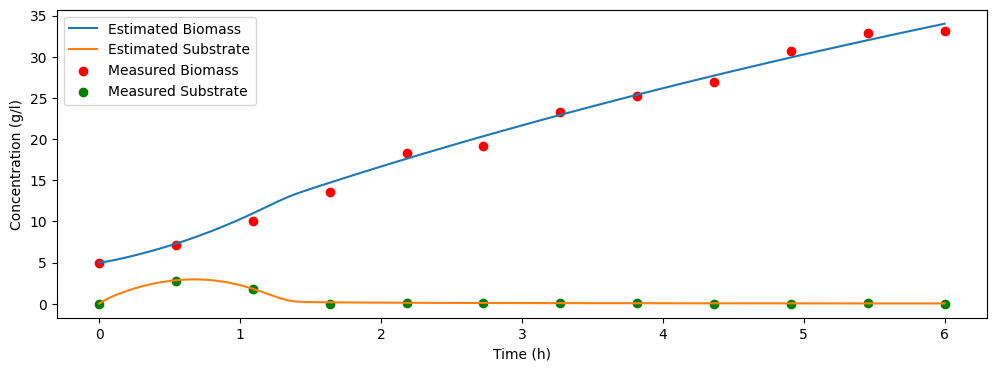

In [24]:
# Solve system_dynamics using estimated parameters
mu_max_est = net.mu_max.item()
K_s_est = net.K_s.item()
Y_xs_est = net.Y_xs.item()

# System dynamics
def system_dynamics(t, y, F) -> np.array:
    X, S, V = y
    dX_dt = (mu_max_est * S / (K_s_est + S)) * X - (F / V) * X
    dS_dt = -(1 / Y_xs_est) * (mu_max_est * S / (K_s_est + S)) * X + (F / V) * (S_F - S)
    dV_dt = F
    return np.array([dX_dt, dS_dt, dV_dt])

# Solve ODE with estimated parameters
t_span = [T_START, T_END]
y0 = [X_0, S_0, V_0]
t_eval = np.linspace(T_START, T_END, 100)
sol_est = solve_ode(system_dynamics, t_span=t_span, y0=y0, method=ODE_SOLVER, t_eval=t_eval, args=(F_0,))
X_est = sol_est.y[0]
S_est = sol_est.y[1]
V_est = sol_est.y[2]

# Plot estimated solution
plt.figure(figsize=(12, 4))
plt.plot(sol_est.t, X_est, label='Estimated Biomass')
plt.plot(sol_est.t, S_est, label='Estimated Substrate')
plt.scatter(sol.t, sol.y[0], label='Measured Biomass', color='red')
plt.scatter(sol.t, sol.y[1], label='Measured Substrate', color='green')
plt.xlabel('Time (h)')
plt.ylabel('Concentration (g/l)')
plt.legend()
plt.show()
